In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('poster')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [106]:
genome_df = sf.load_genome('MED4')

In [107]:
genome_df.head()

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence,genome,left,right
0,MED4,PMED4_0001,fig|1218.84.peg.1,peg,MED4_174_1331,174,1331,+,DNA polymerase III beta subunit (EC 2.7.7.7),NaN,FIG00066425,isu;DNA-replication isu;DNA_replication_cluster_1,atggagattgtttgtaatcaaaatgaatttaattatgctattcaat...,MEIVCNQNEFNYAIQLVSKAVASRPTHPILANLLLTADQGTNKISL...,MED4,174,1331
1,MED4,PMED4_0002,fig|1218.84.peg.2,peg,MED4_1333_2040,1333,2040,+,hypothetical protein,NaN,NaN,NaN,ttgaaattaccaaaagaatttttattaagtgaattattaagacata...,MKLPKEFLLSELLRHNVKGNATLNYGKGENVWMHPPVHRILGWYSR...,MED4,1333,2040
2,MED4,PMED4_0003,fig|1218.84.peg.3,peg,MED4_2044_4383,2044,4383,+,"Phosphoribosylformylglycinamidine synthase, sy...",NaN,FIG01303876,icw(1);De_Novo_Purine_Biosynthesis,atgatagattcttcaagtaacaatacttatgatgttaatgaatcac...,MIDSSSNNTYDVNESLKVENLTRDDYEEICKRLGRKPNRTELGMFG...,MED4,2044,4383
3,MED4,PMED4_0004,fig|1218.84.peg.4,peg,MED4_4430_5890,4430,5890,+,Amidophosphoribosyltransferase (EC 2.4.2.14),NaN,FIG00000179,isu;YgfZ isu;De_Novo_Purine_Biosynthesis,atgtgtggaattgttggaattgtttcttgtgatgatgtaaatcaac...,MCGIVGIVSCDDVNQQIYDSLLLLQHRGQDSTGIATMENTVFHIHK...,MED4,4430,5890
4,MED4,PMED4_0005,fig|1218.84.peg.5,peg,MED4_8259_5887,8259,5887,-,DNA gyrase subunit A (EC 5.99.1.3),NaN,FIG00000080,idu(1);DNA_gyrase_subunits idu(1);DNA_topoisom...,atgagtgtgataataggacgtgctttacctgatgcaagagatggac...,MSVIIGRALPDARDGLKPVQRRILFAMHELGLTPDRPFRKCARVVG...,MED4,5887,8259


In [109]:
genome_df.contig_id.nunique()

1

In [79]:
otype_order = [
    'known',
    'standalone',
    'as',
    'as_internal',
    'as_internal_out_frame',
    'as_out_frame',
    'internal_out_frame',
    'downstream_out_frame',
    'downstream_upstream_out_frame',
    'upstream_out_frame',
    'internal',
    'downstream',
    'upstream',
    'overlap_many',
]
otype_palette = ['blue', 'yellow'] + sns.color_palette("Reds", 4).as_hex() + \
    sns.color_palette("Greens", 4).as_hex() + \
    sns.color_palette("Purples", 4).as_hex() 
    

In [95]:
otype_map = {
    'known' : 'known' ,
    'standalone' : 'standalone',
    'as' : 'as',
    'as_internal' : 'as',
    'as_internal_out_frame' : 'as',
    'as_out_frame' : 'as',
    'internal_out_frame' : 'out_frame',
    'downstream_out_frame' : 'out_frame',
    'downstream_upstream_out_frame' : 'out_frame',
    'upstream_out_frame' : 'out_frame',
    'internal' : 'overlap',
    'downstream' : 'overlap',
    'upstream' : 'overlap',
    'downstream_upstream' : 'overlap',
    'overlap_many' : 'overlap',
}
oorder = ['standalone', 'out_frame', 'as', 'overlap', 'known', ]

In [129]:
d1 = df.groupby(['otype'])['orfid'].count().reset_index()
d2 = df.loc[df.len_aa < 100].groupby(['otype'])['orfid'].count().reset_index()
d3 = df.loc[df.len_aa < 50].groupby(['otype'])['orfid'].count().reset_index()
d1['subset'] = 'all'
d1.rename(columns={'orfid':'count'}, inplace=True)
d2['subset'] = '<100aa'
d2.rename(columns={'orfid':'count'}, inplace=True)
d3['subset'] = '<50aa'
d3.rename(columns={'orfid':'count'}, inplace=True)

summary_df = pd.concat([d1,d2,d3])


In [ ]:
summary_df.to_csv()

In [121]:
df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'is_downstream', 'is_inside', 'is_out_of_frame',
       'is_same_strand', 'is_upstream', 'overlap_count', 'overlap_gene_type',
       'overlap_location', 'overlap_strand', 'overlap_type', 'otype'],
      dtype='object')

In [94]:
df.loc[df.otype.isna()]

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,is_inside,is_out_of_frame,is_same_strand,is_upstream,overlap_count,overlap_gene_type,overlap_location,overlap_strand,overlap_type,otype
10930,ORF10931_BX548175.1:380903:381019,BX548175.1,380903,381019,380903,381019,+,MSLARRTPADVAELVDALVSGTSGSNVVGVQVSPSALS,117,38,...,0.0,0.0,1.0,1.0,1,rna,MIT9313_380928_381011,+,downstream_upstream,NaN
11797,ORF11798_BX548175.1:755180:755347,BX548175.1,755180,755347,755180,755347,+,MYGSTGEPCYIHEGLKAAGEVAEWSKAQHWKCCIGATLSRVRIPPS...,168,55,...,0.0,0.0,1.0,1.0,1,rna,MIT9313_755235_755321,+,downstream_upstream,NaN


In [96]:
genome = 'MED4'

In [97]:
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))

In [98]:
df['otype'] = df.overlap_type.map(otype_map)

Text(0.5, 1, 'number of orfs - MED4')

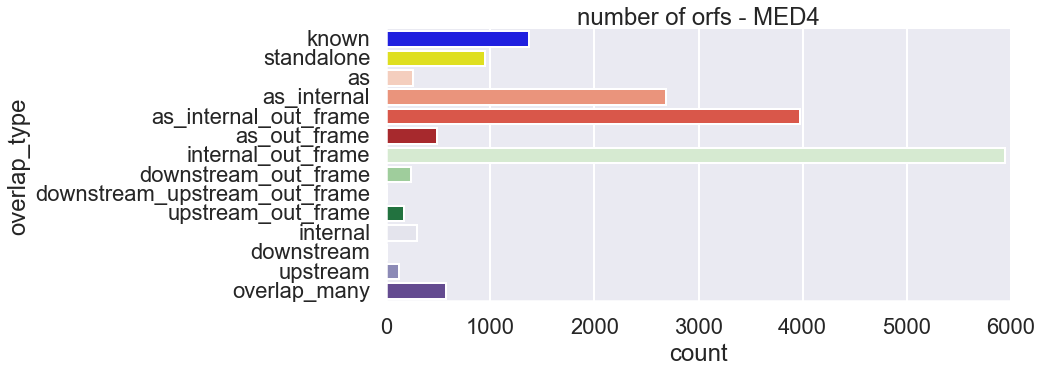

In [99]:
sns.catplot(data=df, y='overlap_type', kind='count', aspect=3,
           order=otype_order, palette=otype_palette)
#plt.xticks(rotation=90) 
plt.title(f'number of orfs - {genome}')

Text(0.5, 1, 'number of orfs - MED4')

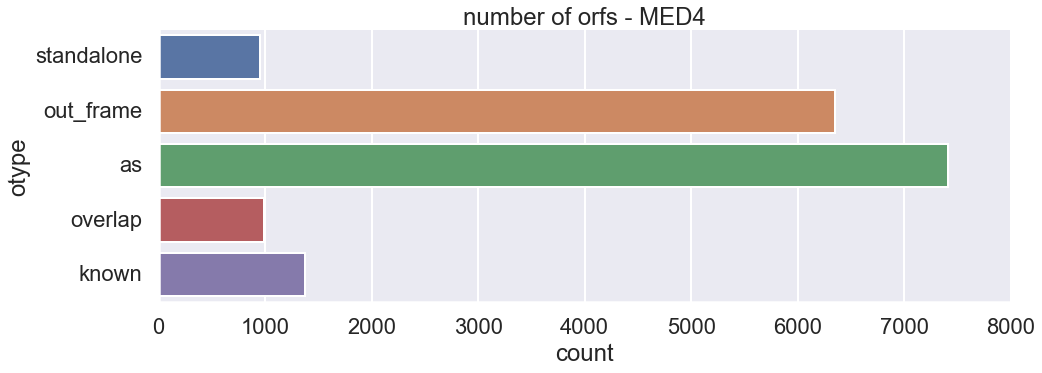

In [117]:
sns.catplot(data=df, y='otype', kind='count', aspect=3,
           order=oorder, #palette=otype_palette
           )
#plt.xticks(rotation=90) 
plt.title(f'number of orfs - {genome}')

Text(0.5, 1, 'number of short orfs (<100aa) - MED4')

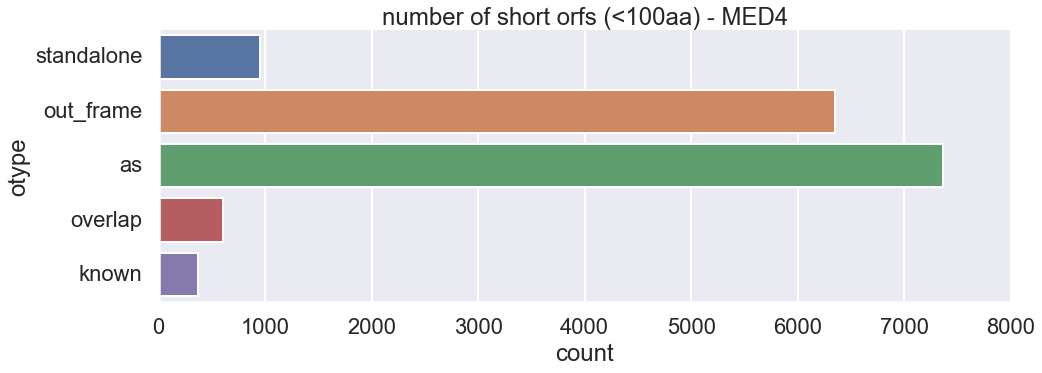

In [111]:
sns.catplot(data=df.loc[df.len_aa<100], y='otype', kind='count', aspect=3,
           order=oorder, #palette=otype_palette
           )
#plt.xticks(rotation=90) 
plt.title(f'number of short orfs (<100aa) - {genome}')

Text(0.5, 1, 'orfs lengths (aa) - MED4')

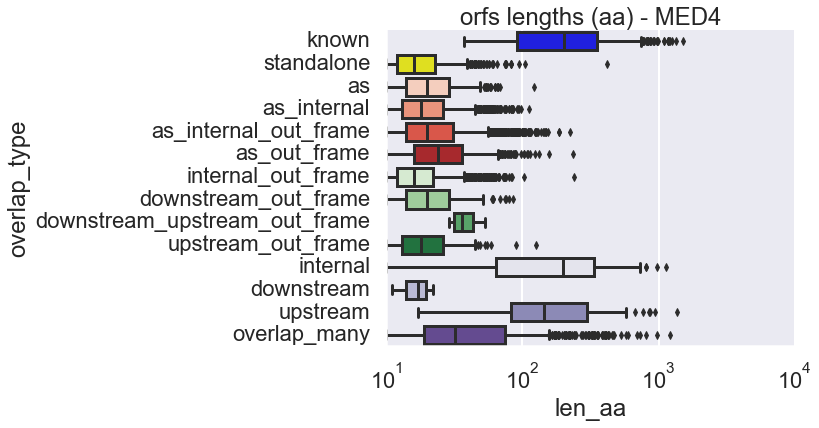

In [101]:
sns.catplot(data=df, y='overlap_type', x='len_aa', aspect=2, height=6,
            kind='box',
           order=otype_order, palette=otype_palette)
plt.xscale('log')
plt.title(f'orfs lengths (aa) - {genome}')

Text(0.5, 1, 'orfs lengths (aa) - MED4')

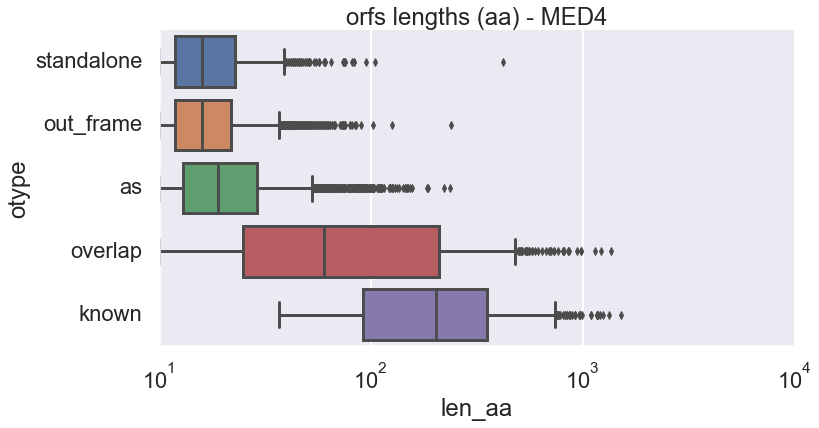

In [102]:
sns.catplot(data=df, y='otype', x='len_aa', aspect=2, height=6,
            kind='box',
           order=oorder, #palette=otype_palette
           )
plt.xscale('log')
plt.title(f'orfs lengths (aa) - {genome}')

In [105]:
df.groupby('otype').len_aa.describe()

,count,mean,std,min,25%,50%,75%,max
otype,,,,,,,,
as,7408.0,24.307505,16.772823,10.0,13.0,19.0,29.0,236.0
known,1370.0,249.455474,197.766218,37.0,92.0,202.5,352.0,1521.0
out_frame,6352.0,18.665302,9.816811,10.0,12.0,16.0,22.0,238.0
overlap,989.0,139.652174,170.684014,10.0,25.0,60.0,210.0,1366.0
standalone,950.0,19.863158,17.174313,10.0,12.0,16.0,23.0,420.0


In [84]:
genome = 'MIT9313'

In [85]:
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))

Text(0.5, 1, 'number of orfs - MIT9313')

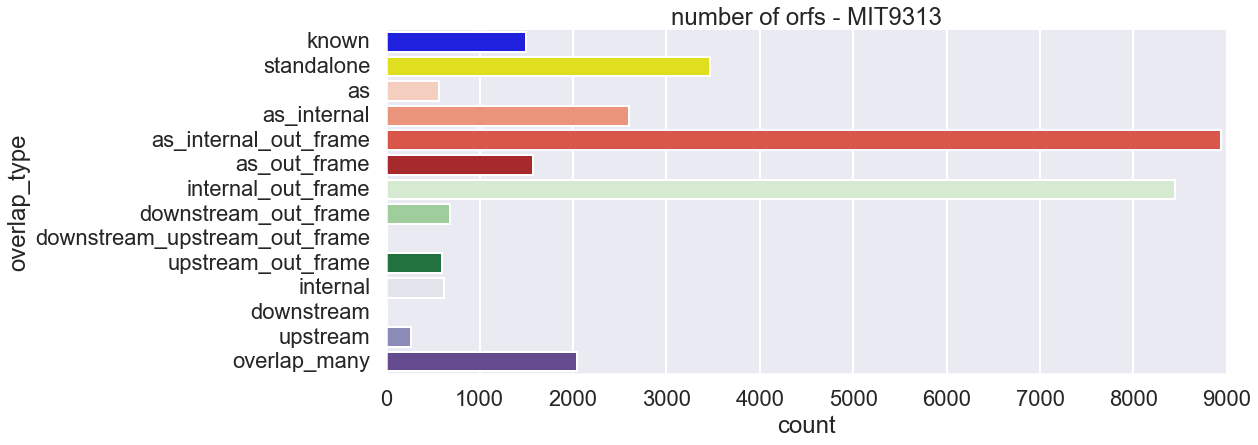

In [89]:
sns.catplot(data=df, y='overlap_type', kind='count', aspect=3, height=6,
           order=otype_order, palette=otype_palette)
#plt.xticks(rotation=90) 
plt.title(f'number of orfs - {genome}')

Text(0.5, 1, 'orfs lengths (aa) - MIT9313')

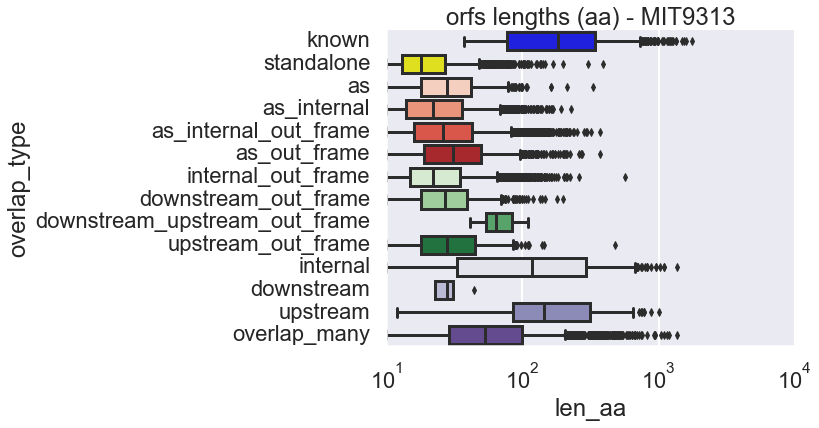

In [87]:
sns.catplot(data=df, y='overlap_type', x='len_aa', aspect=2, height=6,
            kind='box',
           order=otype_order, palette=otype_palette)
plt.xscale('log')
plt.title(f'orfs lengths (aa) - {genome}')

In [88]:
df.groupby(['overlap_type', 'strand', 'overlap_strand', ])['contig'].count()


overlap_type                   strand  overlap_strand
as                             +       -                  276
                               -       +                  294
as_internal                    +       -                 1225
                               -       +                 1373
as_internal_out_frame          +       -                 4061
                               -       +                 4881
as_out_frame                   +       -                  755
                               -       +                  815
downstream                     +       +                    3
                               -       -                    2
downstream_out_frame           +       +                  320
                               -       -                  366
downstream_upstream            +       +                    2
downstream_upstream_out_frame  +       +                    8
                               -       -                    4
internal        

In [75]:
df.groupby(['overlap_gene_type','overlap_type',  ])['contig'].count()


overlap_gene_type  overlap_type                 
                   standalone                       3469
peg                as                                553
                   as_internal                      2582
                   as_internal_out_frame            8910
                   as_out_frame                     1549
                   downstream                          2
                   downstream_out_frame              678
                   downstream_upstream_out_frame       9
                   internal                          601
                   internal_out_frame               8397
                   known                            1496
                   overlap_many                     2023
                   upstream                          263
                   upstream_out_frame                590
peg,rna            overlap_many                       12
rna                as                                 17
                   as_internal         